<a href="https://colab.research.google.com/github/Fayrouz293/tugas_cloudnetworking_dan_cybersecurity/blob/main/TUGAS_FIX.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

INSTALL & IMPORT LIBRARY

In [ ]:
import pandas as pd
import numpy as np
import re
import nltk
import torch

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from imblearn.over_sampling import RandomOverSampler

from transformers import AutoTokenizer, AutoModel
from nltk.corpus import stopwords


In [ ]:
nltk.download('stopwords')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

UPLOAD & LOAD DATASET & SAMPLING DATA (5000)

In [ ]:
df = pd.read_csv('/content/ulasan_whatsapp.csv')
df = df.rename(columns={'content': 'text'})
df.head()


,text
0,"Saya sudah berapa kali upgrade apk ini, tapi t..."
1,pengembang yg songong di bilang ga ada gunanya...
2,Tolong segera update yang terbaru lagi. Karena...
3,"Baru di update,Tetap sama hasilnya. Bug Hijau ..."
4,Untuk Saat Ini WhatsApp Udah Lebih Bagus Dari ...


PREPROCESSING TEKS

In [ ]:
stop_words = set(stopwords.words('indonesian'))

def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'[^a-z\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    tokens = text.split()
    tokens = [t for t in tokens if t not in stop_words]
    return ' '.join(tokens)

df['clean_text'] = df['text'].astype(str).apply(preprocess_text)
df.head()


,text,clean_text
0,"Saya sudah berapa kali upgrade apk ini, tapi t...",kali upgrade apk tdk muncul fitur music nya st...
1,pengembang yg songong di bilang ga ada gunanya...,pengembang yg songong bilang ga gunanya update...
2,Tolong segera update yang terbaru lagi. Karena...,tolong update terbaru versi pangguna mengirim ...
3,"Baru di update,Tetap sama hasilnya. Bug Hijau ...",updatetetap hasilnya bug hijau posting video s...
4,Untuk Saat Ini WhatsApp Udah Lebih Bagus Dari ...,whatsapp udah bagus tingkatkan hd foto video j...


PELABELAN SENTIMEN (LEXICON-BASED)

In [ ]:
def load_lexicon(path):
    with open(path, 'r', encoding='utf8') as f:
        return set(f.read().splitlines())

positive_words = load_lexicon('/content/positive.txt')
negative_words = load_lexicon('/content/negative.txt')


In [ ]:
def sentiment_label(text):
    score = 0
    for word in text.split():
        if word in positive_words:
            score += 1
        elif word in negative_words:
            score -= 1

    if score > 0:
        return 'positif'
    elif score < 0:
        return 'negatif'
    else:
        return 'netral'


In [ ]:
df['sentiment'] = df['clean_text'].apply(sentiment_label)
df['sentiment'].value_counts()


,count
sentiment,
netral,23985
positif,23921
negatif,15094


PEMBAGIAN DATA LATIH & UJI

In [ ]:
X = df['clean_text']
y = df['sentiment']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


IMPLEMENTASI GLOVE (EKSTRAKSI FITUR)

In [ ]:
def load_glove(path):
    embeddings = {}
    with open(path, 'r', encoding='utf8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            vector = np.asarray(values[1:], dtype='float32')
            embeddings[word] = vector
    return embeddings

glove = load_glove('/content/glove.6B.100d.txt')


In [ ]:
def glove_embedding(text):
    vectors = [glove[w] for w in text.split() if w in glove]
    if len(vectors) == 0:
        return np.zeros(100)
    return np.mean(vectors, axis=0)


In [ ]:
X_train_glove = np.array([glove_embedding(t) for t in X_train])
X_test_glove = np.array([glove_embedding(t) for t in X_test])


In [ ]:
def glove_vector(text, embeddings, dim=100):
    vectors = []
    for word in text.split():
        if word in embeddings:
            vectors.append(embeddings[word])
    if len(vectors) == 0:
        return np.zeros(dim)
    return np.mean(vectors, axis=0)

df['glove_vector'] = df['clean_text'].apply(lambda x: glove_vector(x, glove))


In [ ]:
df_final = df[['text', 'glove_vector']]
df_final.head()


,text,glove_vector
0,"Saya sudah berapa kali upgrade apk ini, tapi t...","[-0.1680221, -0.033127982, 0.24121138, 0.09275..."
1,pengembang yg songong di bilang ga ada gunanya...,"[-0.41861412, -0.0631862, 0.46245325, -0.17245..."
2,Tolong segera update yang terbaru lagi. Karena...,"[-0.21730895, -0.15928216, 0.4631332, -0.16545..."
3,"Baru di update,Tetap sama hasilnya. Bug Hijau ...","[0.10101273, -0.22764273, 0.06484363, -0.20704..."
4,Untuk Saat Ini WhatsApp Udah Lebih Bagus Dari ...,"[-0.112771526, -0.028411606, 0.40509608, -0.23..."


IMPLEMENTASI INDOBERT (EKSTRAKSI FITUR)

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("indobenchmark/indobert-base-p1")
model = AutoModel.from_pretrained("indobenchmark/indobert-base-p1")
model.eval()


BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(50000, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False

In [ ]:
def indobert_vector(text):
    inputs = tokenizer(
        text,
        return_tensors="pt",
        truncation=True,
        padding=True,
        max_length=256
    )
    with torch.no_grad():
        outputs = model(**inputs)
    cls_embedding = outputs.last_hidden_state[:, 0, :]
    return cls_embedding.squeeze().numpy()


In [ ]:
from tqdm import tqdm
tqdm.pandas()


In [ ]:
tqdm.pandas()
df = df.head(20000)
df['indobert_vector'] = df['clean_text'].progress_apply(indobert_vector)


100%|██████████| 20000/20000 [39:19<00:00,  8.48it/s]


In [ ]:
df_final = df[['text', 'indobert_vector']]
df_final.head()

,text,indobert_vector
0,"Saya sudah berapa kali upgrade apk ini, tapi t...","[0.9005249, 2.61367, 0.7288119, 0.32490966, 2...."
1,pengembang yg songong di bilang ga ada gunanya...,"[0.99868315, 1.7857064, 0.76745194, 0.35566035..."
2,Tolong segera update yang terbaru lagi. Karena...,"[0.8480837, 2.207978, 0.7675379, 0.35606772, 2..."
3,"Baru di update,Tetap sama hasilnya. Bug Hijau ...","[1.18507, 2.0524065, 0.88961667, 0.35472742, 2..."
4,Untuk Saat Ini WhatsApp Udah Lebih Bagus Dari ...,"[1.4166068, 3.408034, 0.43902633, 0.20058838, ..."


PENGGABUNGAN EMBEDDING (CONCATINATION)

In [ ]:
import numpy as np

def concatenate_embeddings(glove_vec, bert_vec):
    return np.concatenate([bert_vec, glove_vec])

df['concat_vector'] = df.apply(
    lambda row: concatenate_embeddings(row['glove_vector'], row['indobert_vector']),
    axis=1
)


In [ ]:
len(df['concat_vector'].iloc[0])


868

In [ ]:
df_feat = pd.DataFrame({
    'No': range(1, len(df)+1),
    'Feat_1': df['concat_vector'].apply(lambda x: x[0]),
    'Feat_2': df['concat_vector'].apply(lambda x: x[1]),
    'Feat_3': df['concat_vector'].apply(lambda x: x[2]),
})


In [ ]:
df_feat.head()


,No,Feat_1,Feat_2,Feat_3
0,1,0.900525,2.613670,0.728812
1,2,0.998683,1.785706,0.767452
2,3,0.848084,2.207978,0.767538
3,4,1.185070,2.052407,0.889617
4,5,1.416607,3.408034,0.439026


In [ ]:
X = np.vstack(df['concat_vector'].values)
y = df['sentiment'].values


In [ ]:
from collections import Counter

print("Sebelum Oversampling:", Counter(y))


Sebelum Oversampling: Counter({'netral': 7802, 'positif': 7589, 'negatif': 4609})


OVERSAMPLING

In [ ]:
!pip install imbalanced-learn


In [ ]:
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(X, y)


In [ ]:
print("Sesudah Oversampling:", Counter(y_resampled))


Sesudah Oversampling: Counter({'positif': 7802, 'netral': 7802, 'negatif': 7802})


In [ ]:
df_oversampled = pd.DataFrame(X_resampled)
df_oversampled['sentiment'] = y_resampled


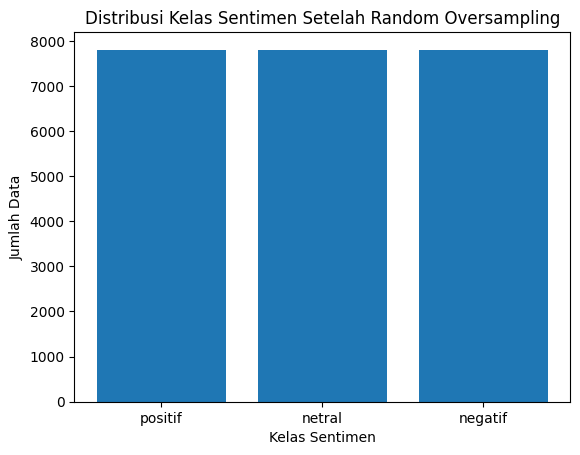

In [ ]:
import matplotlib.pyplot as plt
from collections import Counter

count_after = Counter(y_resampled)

labels = list(count_after.keys())
values = list(count_after.values())

plt.figure()
plt.bar(labels, values)
plt.xlabel("Kelas Sentimen")
plt.ylabel("Jumlah Data")
plt.title("Distribusi Kelas Sentimen Setelah Random Oversampling")
plt.show()


PEMBAGIAN DATA

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_resampled,
    y_resampled,
    test_size=0.2,
    random_state=42,
    stratify=y_resampled
)


In [ ]:
from collections import Counter

print("Distribusi data latih:", Counter(y_train))
print("Distribusi data uji  :", Counter(y_test))


Distribusi data latih: Counter({'negatif': 6242, 'positif': 6241, 'netral': 6241})
Distribusi data uji  : Counter({'netral': 1561, 'positif': 1561, 'negatif': 1560})


In [ ]:
total_data = X_resampled.shape[0]

train_percentage = (X_train.shape[0] / total_data) * 100
test_percentage = (X_test.shape[0] / total_data) * 100

print(f"Total Data        : {total_data}")
print(f"Data Latih        : {X_train.shape[0]} ({train_percentage:.0f}%)")
print(f"Data Uji          : {X_test.shape[0]} ({test_percentage:.0f}%)")


Total Data        : 23406
Data Latih        : 18724 (80%)
Data Uji          : 4682 (20%)


EVALUASI MODEL

In [ ]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(
    max_iter=1000,
    random_state=42
)

clf.fit(X_train, y_train)


LogisticRegression(max_iter=1000, random_state=42)

In [ ]:
y_pred = clf.predict(X_test)


In [ ]:
from sklearn.metrics import classification_report

print(classification_report(
    y_test,
    y_pred,
    target_names=['Negatif', 'Netral', 'Positif']
))


              precision    recall  f1-score   support

     Negatif       0.71      0.75      0.73      1560
      Netral       0.65      0.62      0.63      1561
     Positif       0.73      0.72      0.72      1561

    accuracy                           0.70      4682
   macro avg       0.70      0.70      0.70      4682
weighted avg       0.70      0.70      0.70      4682



CONFUSION MATRIX

<Figure size 640x480 with 0 Axes>

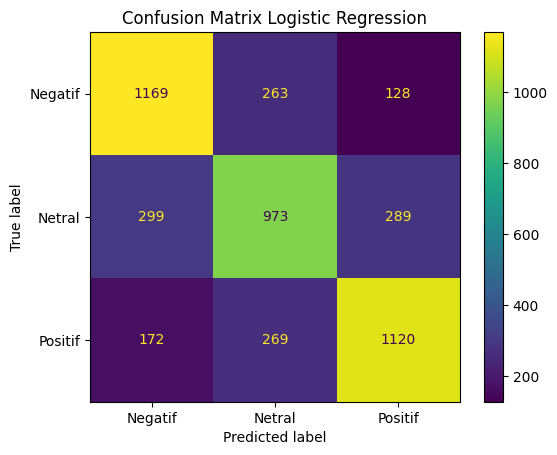

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=['Negatif', 'Netral', 'Positif']
)

plt.figure()
disp.plot()
plt.title("Confusion Matrix Logistic Regression")
plt.show()


PENGUJIAN INDOBERT

In [ ]:
from sklearn.linear_model import LogisticRegression

clf_indobert = LogisticRegression(
    max_iter=1000,
    random_state=42
)

clf_indobert.fit(X_train, y_train)


LogisticRegression(max_iter=1000, random_state=42)

In [ ]:
y_pred = clf_indobert.predict(X_test)


In [ ]:
from sklearn.metrics import classification_report

print(
    classification_report(
        y_test,
        y_pred,
        target_names=['Negatif', 'Netral', 'Positif']
    )
)


              precision    recall  f1-score   support

     Negatif       0.71      0.75      0.73      1560
      Netral       0.65      0.62      0.63      1561
     Positif       0.73      0.72      0.72      1561

    accuracy                           0.70      4682
   macro avg       0.70      0.70      0.70      4682
weighted avg       0.70      0.70      0.70      4682



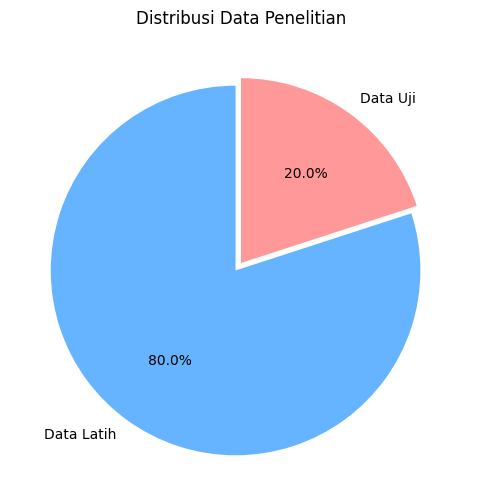

In [ ]:
import matplotlib.pyplot as plt

# Contoh data untuk lingkaran kesimpulan penelitian
labels = ['Data Latih', 'Data Uji']
sizes = [80, 20]  # persentase data
colors = ['#66b3ff','#ff9999']
explode = (0.05, 0)  # sedikit "meledakkan" slice pertama

plt.figure(figsize=(6,6))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, colors=colors, explode=explode)
plt.title('Distribusi Data Penelitian')
plt.show()


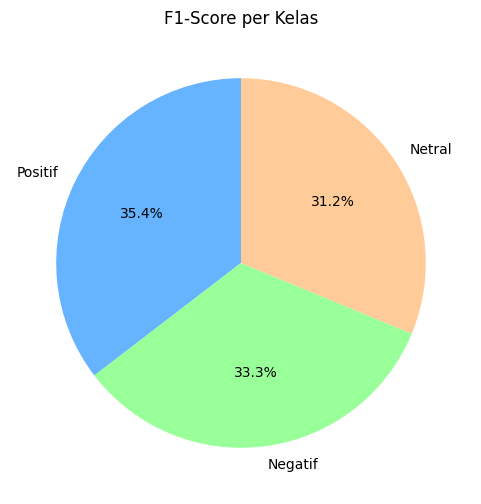

In [ ]:
# Misal hasil evaluasi model SVM
labels = ['Positif', 'Negatif', 'Netral']
scores = [0.85, 0.80, 0.75]  # F1-score masing-masing kelas
colors = ['#66b3ff','#99ff99','#ffcc99']

plt.figure(figsize=(6,6))
plt.pie(scores, labels=labels, autopct='%1.1f%%', startangle=90, colors=colors)
plt.title('F1-Score per Kelas')
plt.show()
